In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from uszipcode import ZipcodeSearchEngine
search = ZipcodeSearchEngine()
%matplotlib inline
import os
import gmaps

gmaps.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [2]:
df_delivery = pd.read_csv('../data/delivery_geography.csv')
df_delivery.head()

,orderid,latitude,longitude,estimateddeliverytime
0,1552679,37.697073,-122.485903,259.0
1,1552697,37.782185,-122.454544,54.0
2,1552675,37.780840,-122.395820,228.0
3,1552934,37.783131,-122.388962,209.0
4,1552983,37.323786,-121.878904,345.0


In [3]:
'Number of rows in df_delivery: {}'.format(len(df_delivery))

'Number of rows in df_delivery: 3780'

'Average estimated delivery time: 227 s with a median of 150 s'

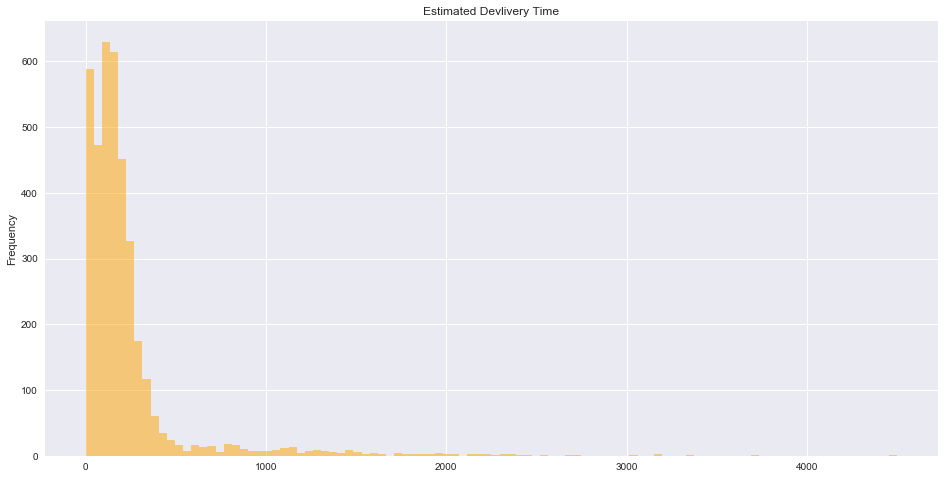

In [4]:
df_delivery.estimateddeliverytime.plot.hist(
    alpha=.5, color='orange', bins=100,  figsize=(16, 8),title ='Estimated Devlivery Time')
'Average estimated delivery time: {} s with a median of {} s'.format(
    "%.0f" % df_delivery['estimateddeliverytime'].mean(), "%.0f" % df_delivery['estimateddeliverytime'].median())

In [5]:
df_prices = pd.read_csv('../data/delivery_prices.csv')
df_prices.head()

,orderid,deliveredat,totalprice
0,1552553,2017-08-08T00:02:29.980+00:00,176.11
1,1552559,2017-08-08T00:09:06.077+00:00,71.03
2,1552499,2017-08-08T00:15:03.847+00:00,61.95
3,1552617,2017-08-08T00:16:40.820+00:00,62.40
4,1552632,2017-08-08T00:31:27.957+00:00,64.16


In [6]:
'Number of rows in df_prices: {}'.format(len(df_prices))

'Number of rows in df_prices: 3352'

'Average total price $69 with a median of $55'

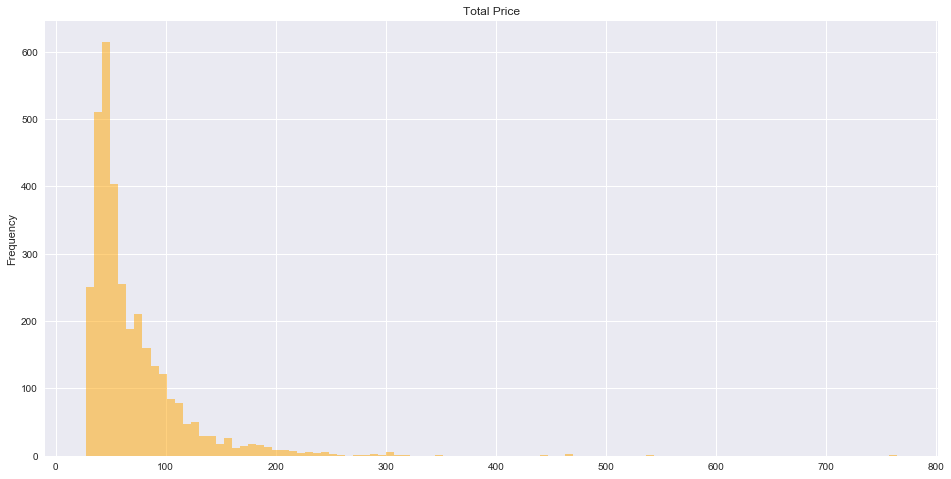

In [7]:
df_prices.totalprice.plot.hist(
    alpha=.5, color='orange', bins=100,  figsize=(16, 8), title ='Total Price')
'Average total price ${} with a median of ${}'.format(
    "%.0f" % df_prices.totalprice.mean(), "%.0f" % df_prices.totalprice.median())

Since the tables are not of equal length we know there will be 428 rows with missing values, calculated below

In [8]:
'Number of incomplete rows: {}'.format(len(df_delivery) - len(df_prices))

'Number of incomplete rows: 428'

# 1. Join these tables in a meaningful way 
Below I'll join the tables with merge on order id. It should be noted that the tables are not of equal size, thus some of the features (columns) will have missing values


In [9]:
# Change the index to 'orderid' column
df_prices = df_prices.set_index('orderid')
df_delivery = df_delivery.set_index('orderid')

In [10]:
# Merge on 'oderid' column
df_join = pd.merge(df_prices,df_delivery, how='outer', left_index=True, right_index=True)
df_join.columns =['date','price','lat','lon','delivery time'] #rename columns
df_join[1020:1025]  #sample of table values 

,date,price,lat,lon,delivery time
orderid,,,,,
1553535,NaN,NaN,34.012453,-118.457838,1077.0
1553536,2017-08-08T02:26:01.213+00:00,43.73,37.779351,-122.497121,235.0
1553537,2017-08-08T02:30:57.383+00:00,137.47,37.807403,-122.301621,172.0
1553538,2017-08-08T02:38:09.680+00:00,56.94,37.748804,-122.423628,20.0
1553539,2017-08-08T03:30:50.513+00:00,65.22,37.485039,-122.192457,119.0


# 2. Find at least one source of external information that you think would augment this table well and add it into the joined table.

- Using the uszipcode 0.1.3 python package I can look up the zipcode, city, and average income for each latitude, longitude entry
- Using the Date Functionality in Pandas will allow the unpacking of the time stamp into days and time, which will give a more granular view of when purchases occur. 

Even thought the sample data did not vary in weekdays this information would be a good metric to know for market exploration purposes.


In [11]:
def geo_data(df, lat, lon):
    '''This function takes a dataframe as input as well the column names as strings for latitude and longitude data.
    It returns the dataframe with zipcode, Average income, and city as columns'''
    # Average income
    df['avg income'] = df.apply(lambda x: search.by_coordinate(x[lat], x[lon], radius=4, returns=1)[
        0]['Wealthy'] if (x[lat] > 0) else None, axis=1).round(0)
    # Zipcode
    df['zipcode'] = df.apply(lambda x:  search.by_coordinate(
        x[lat], x[lon], radius=4, returns=1)[0]['Zipcode'] if (x[lat] > 0) else None, axis=1)
    # city
    df['city'] = df.apply(lambda x:  search.by_coordinate(
        x[lat], x[lon], radius=4, returns=1)[0]['City'] if (x[lat] > 0) else None, axis=1)

In [12]:
geo_data(df_join, 'lat', 'lon')
df_join[1020:1025]  #sample of table values 

,date,price,lat,lon,delivery time,avg income,zipcode,city
orderid,,,,,,,,
1553535,NaN,NaN,34.012453,-118.457838,1077.0,39765.0,90405,Santa Monica
1553536,2017-08-08T02:26:01.213+00:00,43.73,37.779351,-122.497121,235.0,29058.0,94121,San Francisco
1553537,2017-08-08T02:30:57.383+00:00,137.47,37.807403,-122.301621,172.0,14127.0,94607,Oakland
1553538,2017-08-08T02:38:09.680+00:00,56.94,37.748804,-122.423628,20.0,27502.0,94110,San Francisco
1553539,2017-08-08T03:30:50.513+00:00,65.22,37.485039,-122.192457,119.0,14781.0,94063,Redwood City


In [13]:
def df_day(df, timestamp):
    '''This functions converts a string timestamp into pandas datetime structure. 
    It then makes a new column by extacting the weekday.'''
    # Convert string timestamp to pandas datetime
    df[timestamp] = pd.to_datetime(df_join[timestamp])
    # Make new column with weekday
    df['day'] = df[timestamp].dt.weekday_name

In [14]:
df_day(df_join, 'date')
df_join[1020:1025]  #sample of table values 

,date,price,lat,lon,delivery time,avg income,zipcode,city,day
orderid,,,,,,,,,
1553535,NaT,NaN,34.012453,-118.457838,1077.0,39765.0,90405,Santa Monica,NaN
1553536,2017-08-08 02:26:01.213,43.73,37.779351,-122.497121,235.0,29058.0,94121,San Francisco,Tuesday
1553537,2017-08-08 02:30:57.383,137.47,37.807403,-122.301621,172.0,14127.0,94607,Oakland,Tuesday
1553538,2017-08-08 02:38:09.680,56.94,37.748804,-122.423628,20.0,27502.0,94110,San Francisco,Tuesday
1553539,2017-08-08 03:30:50.513,65.22,37.485039,-122.192457,119.0,14781.0,94063,Redwood City,Tuesday


In [15]:
# Count the instances for each weekday
df_join.day.value_counts()

Tuesday    3352
Name: day, dtype: int64

# 3. Explain (at a high level) how you would perform this join on a live data pipeline in a performant way.

To perform this join on a pipeline I would implement with the join SQL command, e.g, FULL OUTER JOIN. Or design the data capture to record to a single table instead of two. 


# 4. Use any clustering/classification technique to divide the data into at least 3 and at most 20 groups. Annotate your joined table with this classification.

Break off pivot tables using the cities group and aggregate income.  


In [16]:
df_city_group = (df_join.set_index('city').groupby(level=0)['price']
                 .agg({'avg purchase': np.mean, 'sum': np.sum, 'avg time': np.mean})
                 .astype(int))

In [17]:
# Sort by avg purchase 
df_city_group.sort_values(by='avg purchase', ascending=False).head()

,avg purchase,sum,avg time
city,,,
Laguna Hills,126,252,126
Aptos,126,3548,126
Santa Ana,113,226,113
Costa Mesa,113,1021,113
San Ysidro,106,106,106


In [18]:
# Sort by sum of purchases 
df_city_group.sort_values(by='sum', ascending=False).head()

,avg purchase,sum,avg time
city,,,
San Francisco,71,72295,71
Oakland,63,21071,63
San Diego,70,16746,70
San Mateo,69,10443,69
Santa Cruz,85,8987,85


In [19]:
# Sort by avg delivery time
df_city_group.sort_values(by='avg time', ascending=False).head()

,avg purchase,sum,avg time
city,,,
Laguna Hills,126,252,126
Aptos,126,3548,126
Santa Ana,113,226,113
Costa Mesa,113,1021,113
San Ysidro,106,106,106


# 5. Create any visualization of the data that you think would display meaningful insight.

Make historgrams of cities, prices, days. 


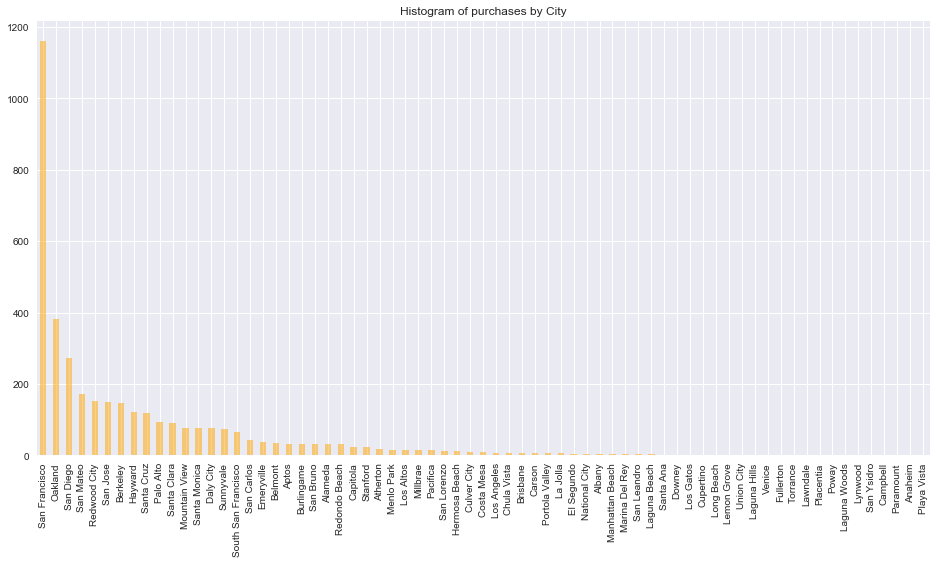

In [20]:
df_join.city.value_counts().plot(kind='bar', alpha=.5, color='orange',  figsize=(16, 8), title ='Histogram of purchases by City'); 

# 6. Explain (at a high level) how you could use any insights derived above to advance the company financially.


In [42]:
# load a Numpy array of (latitude, longitude) pairs from dataframe 
locations =  df_join[["lat", "lon"]].dropna()
# Center map on bakersfield
bakersfield_coord= (35.376175, -119.022102)
fig = gmaps.figure(center=bakersfield_coord, zoom_level=6)
# Generate heatmap for locations 
fig.add_layer(gmaps.heatmap_layer(locations))
fig

Figure()

Tools used to plot google maps 
http://jupyter-gmaps.readthedocs.io/en/latest/gmaps.html#heatmaps
http://colorbrewer2.org/#type=sequential&scheme=YlOrRd&n=3
https://github.com/pbugnion/gmaps